# Prediccón de gastos medicos

Para utilizar este notebook seguir los pasos listados a continuación:
1. Descargar dataset desde Kaggle ([Medical Cost Personal Dataset](https://www.kaggle.com/datasets/mirichoi0218/insurance?select=insurance.csv))
2. Descomprimir el arhcivo `.zip`
3. Colocar el archivo `insurance.csv` en la carpeta `data/raw`


Columnas (variables) del dataset:
- `age`: Edad del asegurado
- `sex`: Género binario del asegurado
- `bmi`: Indice de masa corporal
- `children`: Cantidad de hijos
- `smoker`: Si el paciente es fumador o no fumador
- `region`: Región en la que vive el paciente
- `charges`: La cantidad que pagó de seguro

## Librerías 

In [54]:
# Comandos para importar modulos propios de este proyecto.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [55]:
# Manipulación y visualización de datos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Crear y entrenar el modelo
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split # Separa los datos en dos conjuntos distintos, uno para entrenamiento y otro para test

# Metricas para evaluar el modelo
from sklearn.metrics import r2_score, mean_squared_error

# Manejo de rutas
import sys
sys.path.append("..")

import modules.utils.paths as path

# Configuración de seaborn
sns.set_style(style="whitegrid")

In [56]:
%pip install setuptools==58

Note: you may need to restart the kernel to use updated packages.


In [57]:
%pip install regressors

Note: you may need to restart the kernel to use updated packages.


## Carga de los datos

In [58]:
file_path = path.data_raw_dir("insurance.csv")

df = pd.read_csv(file_path)
display(df.shape, df.head())

(1338, 7)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Primer vistazo a los datos

¿Cuales son los estadisticos que describen mejor a los datos?

In [59]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


¿Con que tipos de datos contamos?

In [60]:
display(
  df.info(),
  df.dtypes.value_counts(),
  df.head(3)
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None

object     3
int64      2
float64    2
dtype: int64

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


In [61]:
df["smoker"].unique()

array(['yes', 'no'], dtype=object)

¿Existen valores faltantes o valores duplicados en el dataset?

In [62]:
print("Total de valores faltantes:", df.isna().sum().sum())
print("Total de valores duplicados:", df.duplicated().sum())

Total de valores faltantes: 0
Total de valores duplicados: 1


In [63]:
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


## Limpieza

En el vistazo inicial de los datos encontramos dos aspectos importantes
1. La variable `smoker` tiene dos valores `yes` y `no`, la cual transformaremos a valores booleanos.
2. Existe un registro repedido en el dataset, el cual eliminaremos

In [64]:
# Cambio de tipo de dato
df["smoker"] = df["smoker"].apply(lambda s: True if s == "yes" else False)
display(
  df["smoker"].dtype,
  df["smoker"].unique()
)

dtype('bool')

array([ True, False])

In [65]:
df.drop_duplicates(keep="first", inplace=True)
print("Total de valores duplicados:", df.duplicated().sum())

Total de valores duplicados: 0


## Análisis de los datos

¿Cuál es la proporción general de las variables categóricas?

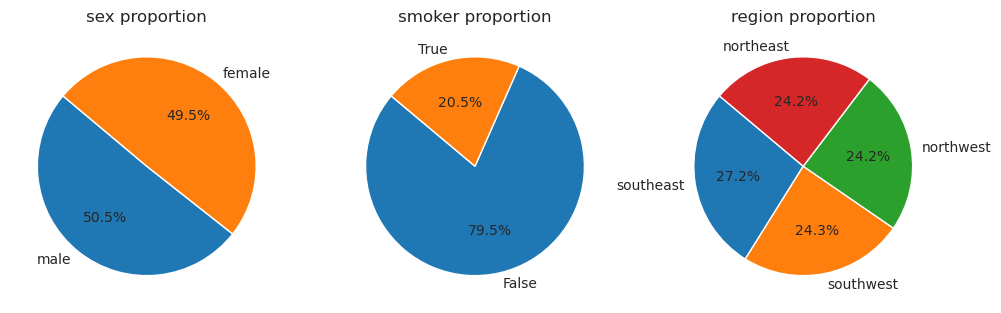

In [66]:
colum_names = df.select_dtypes(include=["object", "boolean"]).columns

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12,5))
axes = axes.flatten()

for ax, column in zip(axes, colum_names):
  cat_data = df[column].value_counts()
  ax.pie(
    x=cat_data,
    labels=cat_data.index,
    autopct="%1.1f%%",
    startangle=140
  )
  ax.set_title(f"{column} proportion")


**Observaciones**
- Las variables `sex` y `region` cuentan con proporciones similares entre sus respectivas categorías. 
- En genral contamos con datos mayormente de paciones NO fumadores.


Me surge la pregunta, ¿cómo es la propocion de estas variables en relación con las otras variables categóricas?
- De entre las personas que son fumadoras, ¿cuantas son hombres y cuantas mujeres? 
- ¿Cuál es la proporción de personas fumadoras por región?
- ¿Cuál es la proporción de hombres y mujeres por región?

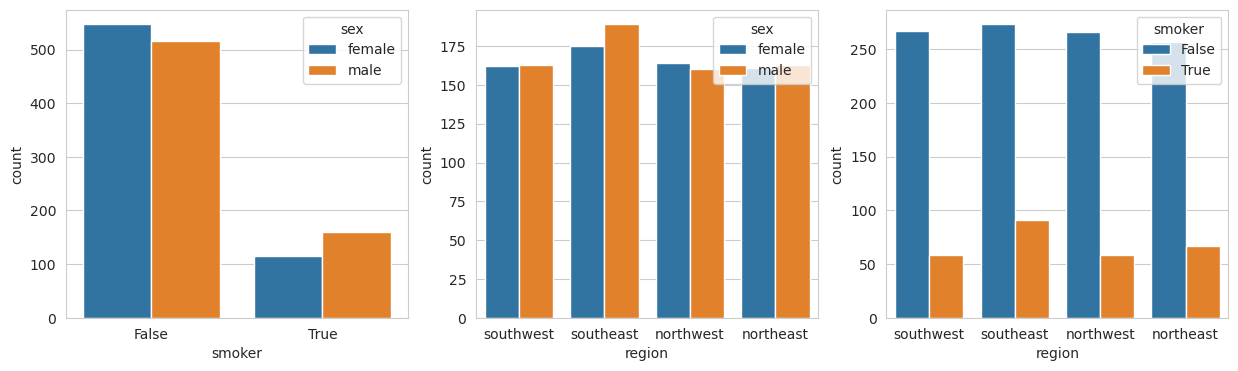

In [67]:
combinations = [
  { "col": "smoker", "hue": "sex"},
  { "col": "region", "hue": "sex"},
  { "col": "region", "hue": "smoker"}
]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

axes=axes.flatten()

for ax, comb in zip(axes, combinations):
  sns.countplot(
    data=df,
    x=comb["col"],
    hue=comb["hue"],
    ax=ax
  )

**Observaciones**
- La proporción general de `smoker`, `region` y `sex` es muy similar a que si las segmentamos por las otras variables vategóricas.

¿Cuál es la distribución de las variables numéricas?

,count,mean,std,min,25%,50%,75%,max
age,1337.0,39.222139,14.044333,18.0000,27.000,39.0000,51.00000,64.00000
bmi,1337.0,30.663452,6.100468,15.9600,26.290,30.4000,34.70000,53.13000
children,1337.0,1.095737,1.205571,0.0000,0.000,1.0000,2.00000,5.00000
charges,1337.0,13279.121487,12110.359656,1121.8739,4746.344,9386.1613,16657.71745,63770.42801


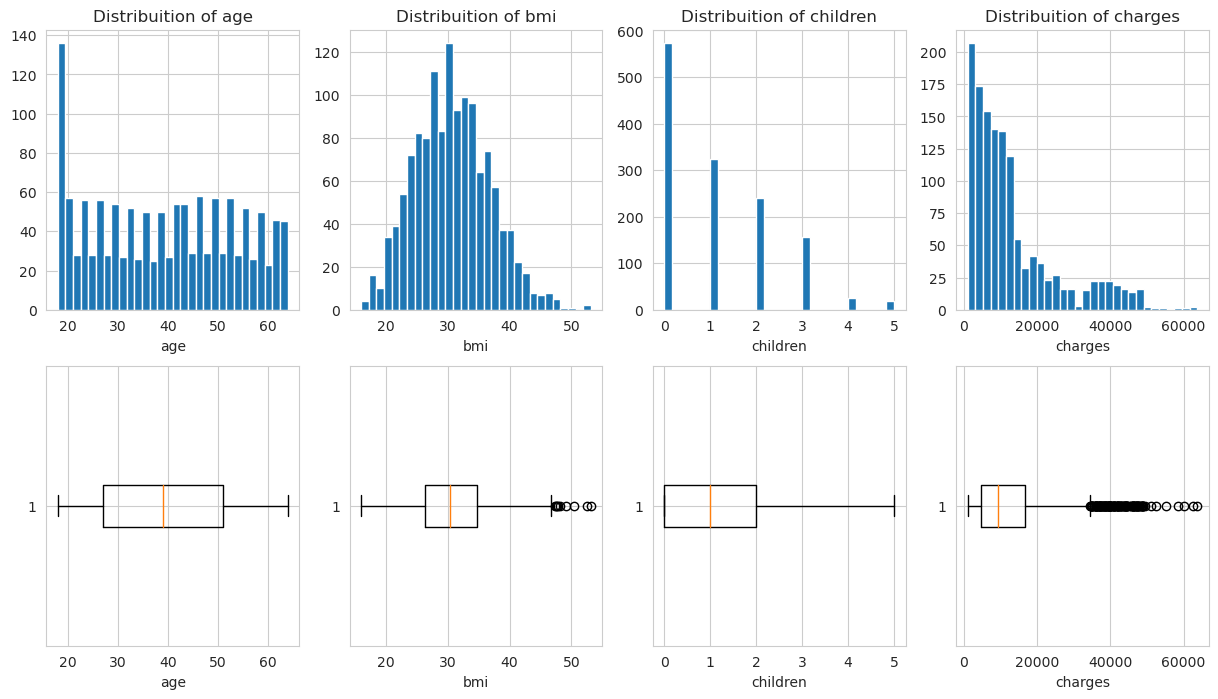

In [68]:
number_columns = df.select_dtypes(include=np.number).columns

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15,8))
# axes = axes.flatten()
ncol = 0
for name in number_columns:
  axes[0, ncol].hist(
    x=df[name],
    bins=30
  )
  axes[0, ncol].set_title(f"Distribuition of {name}")
  axes[0, ncol].set_xlabel(name)
  
  axes[1, ncol].boxplot(
    x=df[name],
    vert=False
  )
  axes[1, ncol].set_xlabel(name)
  
  ncol+=1
  
  
df.describe().T

**Observaciones**
- La variable a predecir (`charges`) tiene una distribución asímetrica Positiva. 
- Los datos atípicos en `charges` se encuentran arriva arriva de los $50,000.
- `bmi` sigue una distribución normal con datos atípicos concentrados a partir de los 48-19 bmi.

Para confirmar los valores atipicos en `charges` vamos hacer un zoom in a su distirbución:

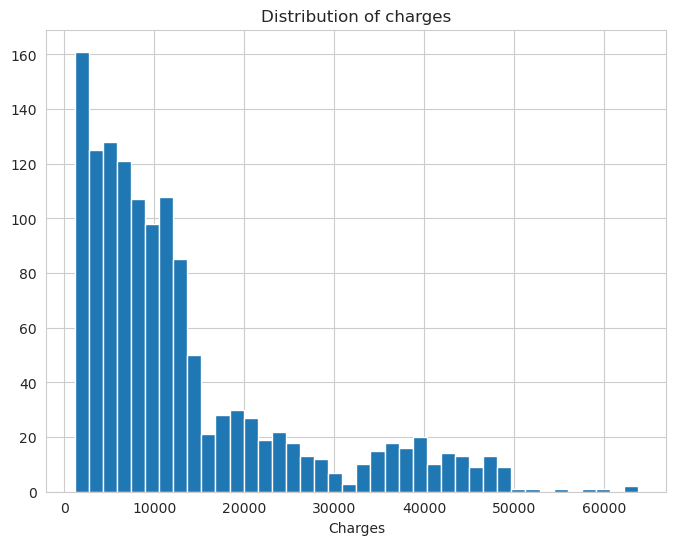

In [69]:
plt.figure(figsize=(8,6))
plt.hist(
  x=df["charges"],
  bins=40
)
plt.title("Distribution of charges")
plt.xlabel("Charges");

In [70]:
display(
  df[df["charges"] > 50_000].sort_values(by="charges"),
  df[df["charges"] > 50_000].shape
)

,age,sex,bmi,children,smoker,region,charges
34,28,male,36.400,1,True,southwest,51194.55914
1146,60,male,32.800,0,True,southwest,52590.82939
819,33,female,35.530,0,True,northwest,55135.40209
577,31,female,38.095,1,True,northeast,58571.07448
1230,52,male,34.485,3,True,northwest,60021.39897
1300,45,male,30.360,0,True,southeast,62592.87309
543,54,female,47.410,0,True,southeast,63770.42801


(7, 7)

📢 Para fines didacticos, y al ser solo 7 rows con valores atípicos, se procederan a eliminar.

In [71]:
df =df[df["charges"] < 50_000]

## Correlaciones

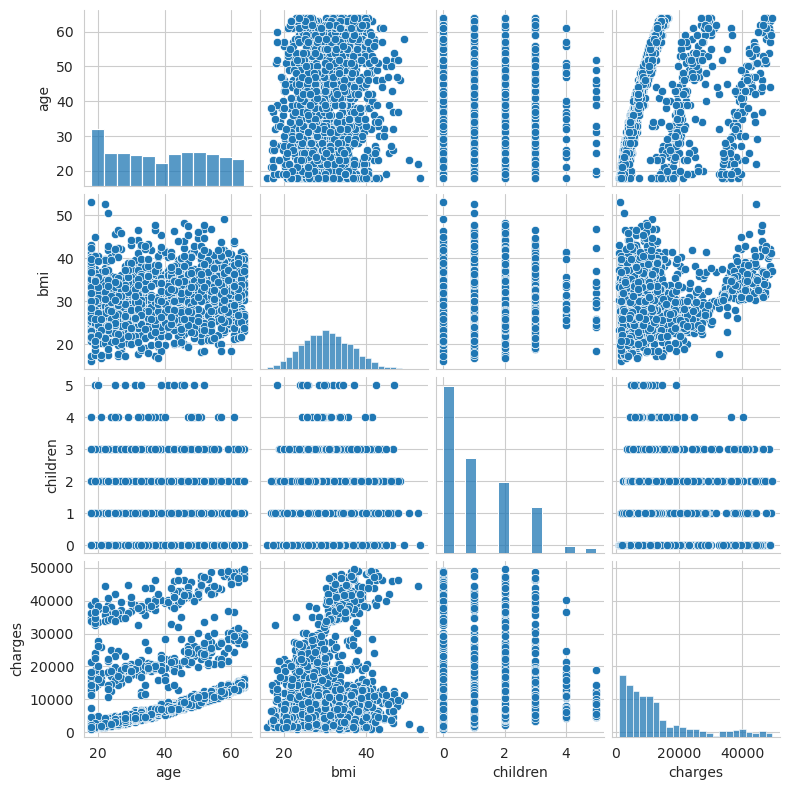

In [72]:
sns.pairplot(data=df[number_columns], height=2)
plt.show()

**Observaciones**
- En la relación `age` y `charges` podemos apreciar tres grupos diferentes; este observación puede análizarse a profundidad en un futuro.
- Las variables se distribuyen de manera esperada. 

### Coeficiente de correlación y mapa de calor

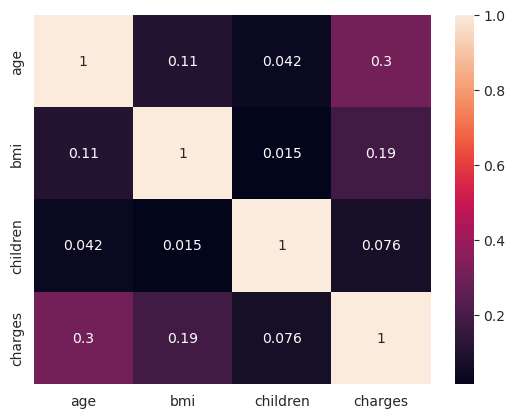

In [73]:
cm = np.corrcoef(df[number_columns].values.T)
sns.heatmap(
  data=cm,
  annot=True,
  yticklabels=number_columns,
  xticklabels=number_columns
)
plt.show()

## Encoding de variables categóricas

También llamadas "_dummie variables_", transformación de variables categóricas a valores numéricos, el método se llama `One Hot Encoding` y coniste en:
- Crear un columna nueva en el Data Frame para cada valor único de la variable categórica.
- El valor $1$ representa la presencia de la variable en la observación (row).
- El valor $0$ representa la ausencia de la variable (valor) de la observación (row).

In [74]:
df = pd.get_dummies(df, columns=colum_names, drop_first=True)
df.head()

,age,bmi,children,charges,sex_male,smoker_True,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


## Creación del modelo

In [75]:
# Definimos las columnas en 2 conjuntos diferentes, en columnas(variables) para entrenamiento y test
Y_cols = ["charges"] # Variable a predecir
X_cols = list(set(df.columns) - set(Y_cols)) # Variables predictoras

# Creamos conjuntos de datos separados por columnas
X = df[X_cols].values
Y = df[Y_cols].values

# Separamos los datos en un conjunto de datos de entrenamiento y otro para test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

# Creamos el scaler para las variables independientes y la varible dependiente.
x_scaller = StandardScaler()
y_scaller = StandardScaler()

# Ajustamos y transformamos los datos de entrenamiento
X_train_scaled = x_scaller.fit_transform(X_train)
Y_train_scaled = y_scaller.fit_transform(Y_train)

# Solo transformamos los datos de prueba con los parámetros de entrenamiento
X_test_scaled = x_scaller.transform(X_test)
Y_test_scaled = y_scaller.transform(Y_test)

# Creamos y entrenamos el modelo
lr_model = LinearRegression()

lr_model.fit(X_train_scaled, Y_train_scaled)
y_pred = lr_model.predict(X_test_scaled)

## Evaluación del modelo

### Métricas

In [76]:
mse = mean_squared_error(Y_test_scaled, y_pred)
r2 = r2_score(Y_test_scaled, y_pred)

print("="*6, "Metrics", "="*6)
print(f"MSE: {mse.round(4)}")
print(f"R2: {r2.round(4)}")

====== Metrics ======
MSE: 0.2445
R2: 0.7402


**Observaciones**
- En promedio el modelo comete un error de 0.2445 unidades (al cuadrado) en sus predicciones.
- El 74% de la variabilidad en la variable objetivo puede explicarse con las variables predictoras del modelo.
- En general el modelo tiene un buen entrenamiento.

> 📌 **NOTA**: `MSE` esta calculado con las variables estandarizadas, por lo tanto el resultado esta dentro del rango de la estandarización. En caso de que regresemos las variables a su escala real este número sera más elevado.

### Resumen de los resultados del modelo

In [77]:
from regressors import stats

# Ajustamos la estructura del intercepto y el coeficiente del modelo 
lr_model.intercept_ = lr_model.intercept_[0]
lr_model.coef_ = lr_model.coef_.reshape(-1)

print("="*20, "Summary", "="*20)
stats.summary(lr_model,   X_test_scaled, Y_test_scaled.reshape(-1), X_cols)

==================== Summary ====================
Residuals:
    Min      1Q  Median     3Q    Max
-2.0416 -0.1084  0.1037 0.2356 0.9385


Coefficients:
                  Estimate  Std. Error  t value   p value
_intercept       -0.000000    0.027325  -0.0000  1.000000
children          0.054086    0.028849   1.8748  0.061699
region_southeast -0.049364    0.033645  -1.4672  0.143267
sex_male         -0.006751    0.027371  -0.2467  0.805318
bmi               0.163755    0.028199   5.8071  0.000000
region_southwest -0.055490    0.030947  -1.7931  0.073871
age               0.320016    0.027171  11.7778  0.000000
smoker_True       0.791166    0.026846  29.4700  0.000000
region_northwest -0.022722    0.030352  -0.7486  0.454630
---
R-squared:  0.74025,    Adjusted R-squared:  0.73384
F-statistic: 115.42 on 8 features


### Análisis de residuales

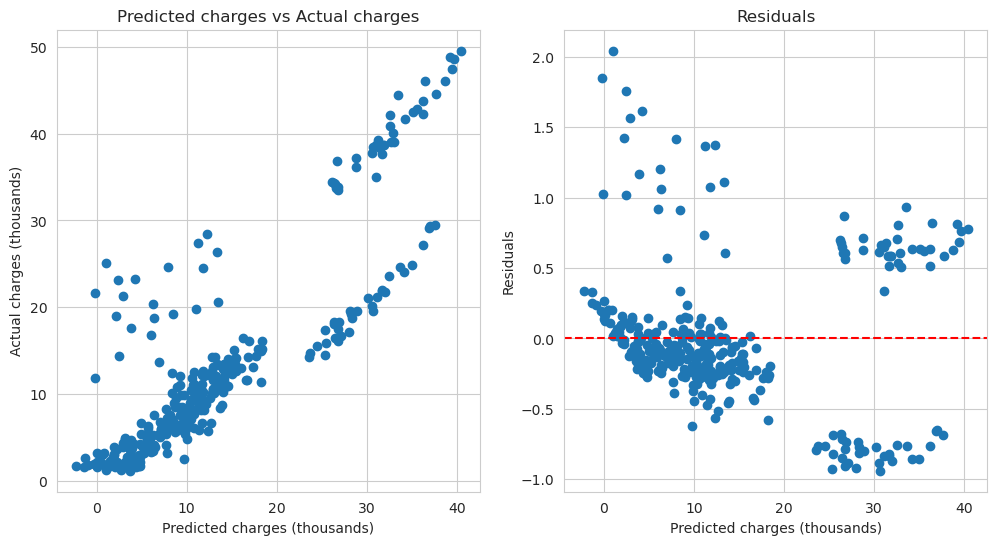

In [78]:
residuals = np.subtract(Y_test_scaled, y_pred)
y_pred_real_scaled = y_scaller.inverse_transform(y_pred)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
axes[0].scatter(
  y_pred_real_scaled/1_000, 
  Y_test/1_000
)

axes[0].set_title("Predicted charges vs Actual charges")
axes[0].set_xlabel("Predicted charges (thousands)")
axes[0].set_ylabel("Actual charges (thousands)")


axes[1].scatter(
  y_pred_real_scaled/1_000, 
  residuals
)
axes[1].axhline(
  y=0,
  color="red",
  linestyle="dashed"
)
axes[1].set_title("Residuals")
axes[1].set_xlabel("Predicted charges (thousands)")
axes[1].set_ylabel("Residuals")
plt.show()

**Observaciones**
- Extite algunas predicciones atipicas que no se ajustan o acercan a la línea roja, la cuál indica la exactitud de la predicción.
- Cuanto más elevado es el valor de `charges` en la predicción mayor es el error.
- A su ves tenemos un grupo amplio de predicciones que se agrupan al rededor de ésta línea.
- En general podemos obtener buenos resultados, sin embargo éste modelo puede mejorarse.

## Mejorando el modelo

Para mejorar esté modelo vamos agregar dos variables adicionales que nos ayuden a comprender mejor la variable a predecir (`charges`):
- `obesity`: Identificar si el paciente tiene o no obesidad. 
  - sobrepeso: BMI esta entre  25 y 29.9
  - obesidad: BMI es mayor o igual a 30
- `obesity*smoker`: Identificar si el paciente tiene sobrepeso y ademas es fumador.


In [ ]:
# Creamos una copia del dataframe 
df_copy = df.copy(deep=True)

# Definimos las variables
df_copy["obesity"] = (df_copy["bmi"] >= 30).astype(int)
df_copy["obesity*smoker"] = df_copy["obesity"] * df["smoker_True"]

In [ ]:
# Definimos las columnas en 2 conjuntos diferentes, en columnas(variables) para entrenamiento y test
Y_cols = ["charges"] # Variable a predecir
X_cols = ["children", "region_southwest", "age", "obesity*smoker", "smoker_True"] # Variables predictoras
# X_cols = list(set(df_copy.columns) - set(Y_cols)) 

# Creamos conjuntos de datos separados por columnas
X = df_copy[X_cols].values
Y = df_copy[Y_cols].values

# Separamos los datos en un conjunto de datos de entrenamiento y otro para test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

# Creamos el scaler para las variables independientes y la varible dependiente.
x_scaller = StandardScaler()
y_scaller = StandardScaler()

# Ajustamos y transformamos los datos de entrenamiento
X_train_scaled = x_scaller.fit_transform(X_train)
Y_train_scaled = y_scaller.fit_transform(Y_train)

# Solo transformamos los datos de prueba con los parámetros de entrenamiento
X_test_scaled = x_scaller.transform(X_test)
Y_test_scaled = y_scaller.transform(Y_test)

# Creamos y entrenamos el modelo
lr_model = LinearRegression()
# lr_model = LinearRegression(fit_intercept=False)

lr_model.fit(X_train_scaled, Y_train_scaled)
y_pred = lr_model.predict(X_test_scaled)

In [128]:
mse = mean_squared_error(Y_test_scaled, y_pred)
r2 = r2_score(Y_test_scaled, y_pred)

print("="*6, "Metrics", "="*6)
print(f"MSE: {mse.round(4)}")
print(f"R2: {r2.round(4)}")

====== Metrics ======
MSE: 0.1286
R2: 0.8634


In [129]:
# Ajustamos la estructura del intercepto y el coeficiente del modelo 
lr_model.intercept_ = lr_model.intercept_[0]
lr_model.coef_ = lr_model.coef_.reshape(-1)

print("="*20, "Summary", "="*20)
stats.summary(lr_model,   X_test_scaled, Y_test_scaled.reshape(-1), X_cols)

==================== Summary ====================
Residuals:
    Min     1Q  Median    3Q    Max
-1.8075 0.0599  0.1087 0.144 0.3875


Coefficients:
                  Estimate  Std. Error  t value   p value
_intercept       -0.000000    0.019694  -0.0000  1.000000
children          0.085365    0.020962   4.0724  0.000058
region_southwest -0.039065    0.019723  -1.9807  0.048453
age2              0.328750    0.019450  16.9022  0.000000
obesity*smoker    0.493243    0.024958  19.7625  0.000000
smoker_True       0.448466    0.024120  18.5932  0.000000
---
R-squared:  0.86335,    Adjusted R-squared:  0.86126
F-statistic: 413.20 on 5 features


### Análisis de residuales (segundo modelo)

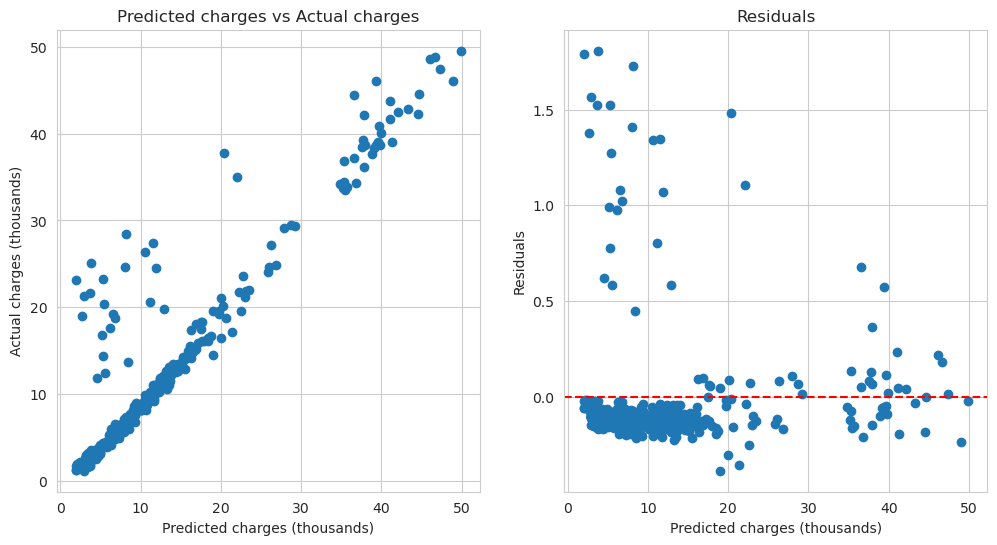

In [130]:
residuals = np.subtract(Y_test_scaled, y_pred)
y_pred_real_scaled = y_scaller.inverse_transform(y_pred)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
axes[0].scatter(
  y_pred_real_scaled/1_000, 
  Y_test/1_000
)

axes[0].set_title("Predicted charges vs Actual charges")
axes[0].set_xlabel("Predicted charges (thousands)")
axes[0].set_ylabel("Actual charges (thousands)")


axes[1].scatter(
  y_pred_real_scaled/1_000, 
  residuals
)
axes[1].axhline(
  y=0,
  color="red",
  linestyle="dashed"
)
axes[1].set_title("Residuals")
axes[1].set_xlabel("Predicted charges (thousands)")
axes[1].set_ylabel("Residuals")
plt.show()

### 📌 NOTAS

**Iteración 1**
- Incluyó ocho variables de entrenamiento.
- Las variables numéricas se estandarizaron con el método `z-score`.
- Las variables categóricas se codificaron con `one hot encoding`.
- Resultados:
  - MSE: 0.2445
  - R2: 0.7402
  - Análisis de residuales: Significativa cantidad de resultados atipicos.


**Iteración 2**
- Se utilizó el Dataframe con las variables numéricas estandarizadas y las variables categóricas codificadas.
- Se añadieron dos variables adicionales; `obesity` y `obesity*smoker` para identificar pacientes con obecidad y pacientes con obecidad y que ademas son fumadores.
- El entrenamiento incluyó diez variables de entrenamiento.
- Resultados:
  - MSE: 0.1284
  - R2: 0.8636
  - Análisis de residuales: La cantidad de resultados atipicos se redujo.

**Iteración 3**
- A partir del resumen del modelo se tomaron las variables con un `p-value` menor a 0.5
- El entrenamiento inclyó las seis variables de entrenamiento con menor `p-value` según la iteración 2.
- Resultados:
  - MSE: 0.1284
  - R2: 0.8636
  - Análisis de residuales: La cantidad de resultados atipicos permaneció similar al resultado de la iteración 2.

**Iteración 4**
- A partir del resumen del modelo se tomaron las variables con un `p-value` menor a 0.5
- El entrenamiento inclyó las cinco variables de entrenamiento con menor `p-value` según la iteración 2.
- Resultados:
  - MSE: 0.1279
  - R2: 0.8641
  - Análisis de residuales: La cantidad de resultados atipicos permaneció similar al resultado de la iteración 3.
